In [9]:
import ee
import geemap.core as geemap
import geemap as gem

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='a448-landsat-down')

from datetime import datetime
from pathlib import Path
import rioxarray
import matplotlib.pyplot as plt

In [7]:
# Define your Area of Interest (example: Long Beach, CA)
roi = ee.Geometry.Point([-122.184628, 46.192022]).buffer(10000).bounds()

# Get a Landsat 7 (LE07) surface reflectance image
collection = (
    ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') 
    .filterBounds(roi) 
    .filterDate('2012-12-25', '2013-02-01') 
    .sort('CLOUD_COVER') 
    #.first()
)

#image = ee.mask.MaskedImage(image,mask=True)
# ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")  # Landsat 8
# ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")  # Landsat 7
# ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")  # Landsat 5


# collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
#     .filterBounds(roi) \
#     .filterDate('2004-05-01', '2004-07-30') \
#     .sort('CLOUD_COVER')

# # Get the image IDs or acquisition dates
# image_ids = collection.aggregate_array('system:id').getInfo()
# image_dates = collection.aggregate_array('system:time_start').getInfo()

# from datetime import datetime

# for i, ts in enumerate(image_dates):
#     date = datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d')
#     print(f"{i+1}. {date} → {image_ids[i]}")

# Function to mask clouds and water for landsat 5
def maskCloudsAndWater(image):
    qa = image.select('QA_PIXEL')
    # Bits 1 and 2 are cloud shadow and cloud, respectively.
    cloud = qa.bitwiseAnd(1 << 3).eq(0)
    cloudShadows = qa.bitwiseAnd(1 << 5).eq(0)
    # Water bit
    water = qa.bitwiseAnd(1 << 2).eq(0)  # Assuming bit 5 represents water
    mask = cloud.And(cloudShadows).And(water)
    return image.updateMask(mask)

# Apply the cloud and water masking function to the image collection
masked_collection = collection.map(maskCloudsAndWater)

image = ee.Image(masked_collection.first())

timestamp = image.date().format('YYYY-MM-dd HH:mm:ss')

# Convert to string (client-side)
print("🗓️ Acquisition Time:", timestamp.getInfo())

timestamp_str = timestamp.getInfo()

dt = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')

# Get day and month in abbreviated text form
day_abbr = dt.strftime('%a')    # e.g., 'Wed'
month_abbr = dt.strftime('%b')  # e.g., 'Jul'
day_num = dt.day                # e.g., 13
year = dt.year

print(f"🗓️ Acquired on {day_abbr}, {month_abbr} {day_num}")

# Check if the month is a summer month (e.g., June–August)
summer_months = [4, 5, 6, 7, 8]  # You can customize this for your hemisphere
if dt.month in summer_months:
    sixty = 1
else:
    sixty = 0

# --- SCALE and CLIP ---
cloud_cover = image.get('CLOUD_COVER').getInfo()



print(f"☁️ Cloud cover: {cloud_cover:.1f}%")
# Red Band (Band 3)
red = image.select('SR_B3').multiply(0.0000275).add(-0.2).clip(roi)

# NIR Band (Band 4)
nir = image.select('SR_B4').multiply(0.0000275).add(-0.2).clip(roi)

🗓️ Acquisition Time: 2013-01-16 18:52:11
🗓️ Acquired on Wed, Jan 16
☁️ Cloud cover: 40.0%


In [8]:
def download_band(band, name, scale):
    url = band.getDownloadURL({
        'name': name,
        'scale': scale,
        'region': roi,
        'format': 'GeoTIFF'
    })
    print(f"⬇️ Downloading {name} from:\n{url}")
   
data_dir = Path().home() / 'sat_data/ajb/landsat7/'

nir_url = download_band(nir, "nir_band4_l7", scale=30)
red_url = download_band(red, "red_band3_l7", scale=30)


⬇️ Downloading nir_band4_l7 from:
https://earthengine.googleapis.com/v1/projects/a448-landsat-down/thumbnails/3aa25336dd84800b0b303c72c2e973ed-a4d26196600483db6502a50d98d15842:getPixels
⬇️ Downloading red_band3_l7 from:
https://earthengine.googleapis.com/v1/projects/a448-landsat-down/thumbnails/c3fffa4b41b8c1b22ac207f1ab8068e5-8dce0b5baca7e241c65721c35b369612:getPixels


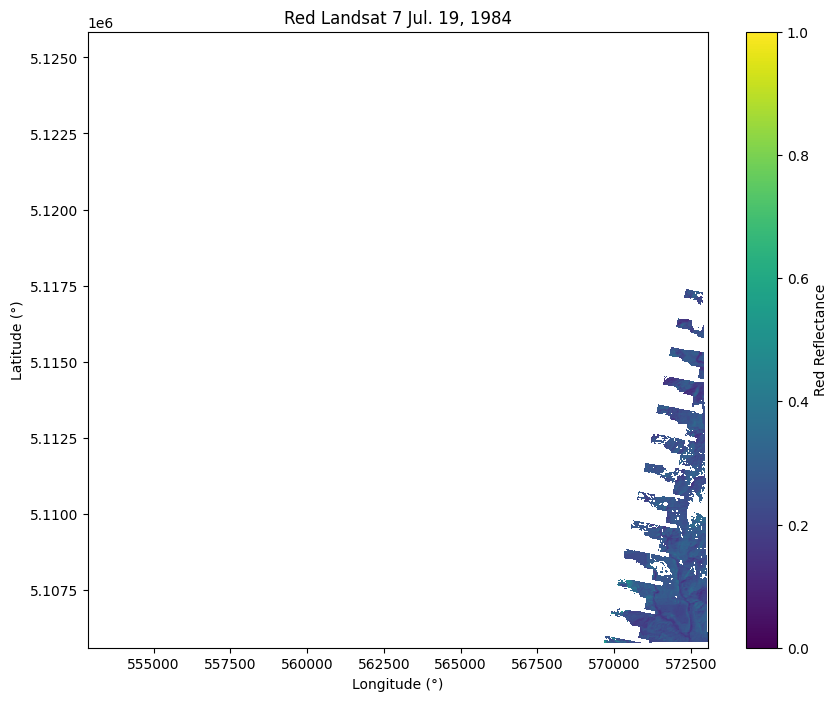

In [94]:
data_dir = Path().home() / 'sat_data/ajb/landsat7/'
#data_dir = Path().home() / "downloads/b3fd24a84c79151630c6d46ff2f69139-8485f08dbe5e8ebe134e935634e690a4_getPixels.tiff"

# Replace with your file path
nir_path = data_dir / 'nir/2011-05-04_nir.tiff'
red_path = data_dir / 'red/2011-05-04_red.tiff'
# Load bands
nir = rioxarray.open_rasterio(nir_path, mask_and_scale=True).squeeze()
#red = rioxarray.open_rasterio(red_path, mask_and_scale=True).squeeze()

# Reproject thermal to match red if needed
#nir = nir.rio.reproject_match(red)

# Plot
#fig, ax = plt.subplots(figsize=(10, 8))

# # Grayscale background (red band)
# red.plot.imshow(ax=ax, cmap='gray', alpha=1.0)

# Convert to lat/lon using .rio.reproject()
#thermal_latlon = thermal.rio.reproject("EPSG:4326")  # WGS 84 (lat/lon)

# Plot with lat/lon axes
fig, ax = plt.subplots(figsize=(10, 8))
nir.plot.imshow(
    ax=ax,
    cmap='viridis',
    vmin=0,
    vmax=1, #if sixty == 0 else 60,
    cbar_kwargs={
        'label': 'Red Reflectance',
        'extend': 'neither'  # this removes the arrow at the end!
    }
)

ax.set_title(f"Red Landsat 7 {month_abbr}. {day_num}, {year}")
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
plt.show()

#import pandas as pd
# Flatten all pixel values and drop NaNs
#values = thermal.values.flatten()
#values = values[~pd.isna(values)]

# Convert to Series and describe
#summary = pd.Series(values).describe()

#print("🌡️ Full Temperature Stats (°C):")
#print(summary)